# Youtube Channel Analysis

In [ ]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime

from apiclient.discovery import build

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Uility functions

def parse_date(datestring):
    return datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%S.%fZ")
  
def parse_duration(duration):
    """ Return seconds from the duration string in iso8601 format
        Simple conversion that does not cover the date parts of the ISO format
    """
    m = re.search(r'(\d+)H', duration)
    dh = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)M', duration)
    dm = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)S', duration)
    ds = int(m.group(1)) if m else 0
    
    return dh*3600 + dm*60 + ds

In [ ]:
# Load Youtube API Key from config.json
with open('./config.json') as f:
    config = json.load(f)
    
api_key = config['youtube']['api_key'] # or your api key

channel_username = "PewDiePie" 


## Creating a Youtube service client

In [ ]:
# Creating the client
client = build('youtube', 'v3', developerKey=api_key)

## Channel Information
Channel info can be retrieved using channel ID or Youtube username.

**Reference:** https://developers.google.com/youtube/v3/docs/channels/list


In [ ]:
# api call: channel list
res = client.channels().list(
    part='snippet,contentDetails,statistics',
    forUsername=channel_username
).execute()
#res

In [6]:
# extract channel informatio
channel_id = res['items'][0]['id']
  
title = res['items'][0]['snippet']['title']
description = res['items'][0]['snippet']['description']
publishedAt = parse_date(res['items'][0]['snippet']['publishedAt'])
imgurl = res['items'][0]['snippet']['thumbnails']['default']['url']
region = res['items'][0]['snippet']['country']

all_playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

viewCount = int(res['items'][0]['statistics']['viewCount'])
subscriberCount = int(res['items'][0]['statistics']['subscriberCount'])
videoCount = int(res['items'][0]['statistics']['videoCount'])

# display channel information
html = """
<table>
<tr><td></td><td><img src="{0}"/></td></tr>
<tr><td style="font-weight:bold">Channel</td><td>{1}</td></tr>
<tr><td style="font-weight:bold">Description</td><td>{2}</td></tr>
<tr><td style="font-weight:bold">Published Date</td><td>{3}</td></tr>
<tr><td style="font-weight:bold">Subscribers</td><td>{4:,}</td></tr>
<tr><td style="font-weight:bold">Total View</td><td>{5:,}</td></tr>
<tr><td style="font-weight:bold">Videos</td><td>{6:,}</td></tr>
</table>
""".format(imgurl, title, description, datetime.strftime(publishedAt, '%b %d, %Y'), 
           subscriberCount, viewCount, videoCount)

display(HTML(html))

,
Channel,PewDiePie
Description,I make videos.
Published Date,"Apr 29, 2010"
Subscribers,"89,295,964"
Total View,"20,712,939,823"
Videos,"3,773"


## Video Category Labels
Video category id & title mapping

**Reference:** https://developers.google.com/youtube/v3/docs/videoCategories/list

In [7]:
res = client.videoCategories().list(part='snippet', regionCode=region).execute()
categories = {}
for item in res['items']:
    categories[item['id']] = item['snippet']['title']
categories


{'1': 'Film & Animation',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '2': 'Autos & Vehicles',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

## Retrieve all Video IDs from the channel

You can get the list of all video ids of a channel by getting the playlist items of the 'uploads' playlist previously retrieved from the channel info

**Reference:** https://developers.google.com/youtube/v3/docs/playlistItems/list

In [8]:
def get_youtube_items(resource, part, **kwargs):
    """ 
    Call list() method of the designated resource param (e.g. playlistItems(), videos(), etc.)
    Then iterate through the entire paginated result set using pageToken parameter.
    Extract and accumulate the content inside the 'items' key.
    """
    res = resource.list(part=part, maxResults=50, **kwargs).execute()
    items = res['items']
    nextPageToken = res.get('nextPageToken','')
    while nextPageToken:
        res = resource.list(part=part, maxResults=50, 
                            pageToken=nextPageToken, **kwargs).execute()
        items = items + res['items']
        nextPageToken = res.get('nextPageToken','')
    return items
  

## Retrieve playlist items from the 'uploads' playlist
items = get_youtube_items(client.playlistItems(), part='snippet', playlistId=all_playlist_id)
print('Video count: {}'.format(len(items)))

Video count: 3774


In [ ]:
# get video id list
video_ids = []

for item in items:
    video_ids.append(item['snippet']['resourceId']['videoId'])

## Retrieve video information and statistics
We'll pass multiple video ids to get their info and statistics through videos().list() instead of calling it individually to reduce the consumption of API quota.

**Reference:** https://developers.google.com/youtube/v3/docs/videos/list

In [10]:
BATCH_SIZE = 35

items = []
curr_idx = 0

# Get video info in batch
while curr_idx <= len(video_ids):
    ids = ','.join(video_ids[curr_idx:curr_idx+BATCH_SIZE])

    res = client.videos().list(
        part='snippet,contentDetails,statistics',
        id=ids
    ).execute()
    items = items + res['items']
    curr_idx = curr_idx + BATCH_SIZE

print('Video info retreived: {}'.format(len(items)))

Video info retreived: 3774


In [11]:
videos = []
for v in items:
    videos.append({
        'id': v['id'],
        'title': v['snippet'].get('title', np.nan),
        'description': v['snippet'].get('description', np.nan),
        'publishedDate': v['snippet'].get('publishedAt', np.nan),
        'image': v['snippet']['thumbnails']['default']['url'],
        'tags': v['snippet'].get('tags', np.nan),
        'categoryId': v['snippet'].get('categoryId', np.nan),
#         'liveBroadcastContent': v['snippet'].get('liveBroadcastContent',np.nan),
        
        'duration': v['contentDetails'].get('duration', np.nan),
#         'licensedContent': v['contentDetails'].get('licensedContent',np.nan),
                
        'view': v['statistics'].get('viewCount', np.nan),
        'like': v['statistics'].get('likeCount', np.nan),
        'dislike': v['statistics'].get('dislikeCount', np.nan),
        'comment': v['statistics'].get('commentCount', np.nan)
        
    })

videos = pd.DataFrame(videos)
videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 12 columns):
categoryId       3774 non-null object
comment          3682 non-null object
description      3774 non-null object
dislike          3765 non-null object
duration         3774 non-null object
id               3774 non-null object
image            3774 non-null object
like             3765 non-null object
publishedDate    3774 non-null object
tags             3703 non-null object
title            3774 non-null object
view             3764 non-null object
dtypes: object(12)
memory usage: 353.9+ KB


## Data cleansing and processing

In [12]:
videos = videos[~videos['view'].isnull()]
videos.isnull().sum()

categoryId        0
comment          83
description       0
dislike           0
duration          0
id                0
image             0
like              0
publishedDate     0
tags             71
title             0
view              0
dtype: int64

In [13]:
# Transform
videos = videos.assign(
          title=videos['title'].str.strip(),
          description=videos['description'].str.strip(),

          # mapping category titles
          category=videos['categoryId'].map(categories),
    
          # duration in minute
          duration=videos['duration'].apply(parse_duration)/60,
    
          # type conversions
          view=videos['view'].astype(int, errors='ignore'),
          like=videos['like'].astype(int, errors='ignore'),
          dislike=videos['dislike'].astype(int, errors='ignore'),
    
          publishedDate=videos['publishedDate'].apply(parse_date)
)

videos['comment_allowed'] = ~videos['comment'].isnull()
videos['comment'] = videos['comment'].fillna(0)
videos['comment'] = videos['comment'].astype(int)

videos['like_pct'] = videos['like']/videos['view']
videos['dislike_pct'] = videos['dislike']/videos['view']
videos['comment_pct'] = videos['comment']/videos['view']

now = datetime.now()
videos['age'] = videos['publishedDate'].apply(lambda x: (now - x).days)

videos.to_csv('videos.csv', encoding='utf-8', index=False)


cols = ['id','title','description','image','category','publishedDate','duration', 
 'view','like','like_pct','dislike','dislike_pct',
 'comment','comment_allowed','comment_pct','age','tags'
]
videos = videos[cols]
videos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3764 entries, 0 to 3773
Data columns (total 17 columns):
id                 3764 non-null object
title              3764 non-null object
description        3764 non-null object
image              3764 non-null object
category           3764 non-null object
publishedDate      3764 non-null datetime64[ns]
duration           3764 non-null float64
view               3764 non-null int64
like               3764 non-null int64
like_pct           3764 non-null float64
dislike            3764 non-null int64
dislike_pct        3764 non-null float64
comment            3764 non-null int64
comment_allowed    3764 non-null bool
comment_pct        3764 non-null float64
age                3764 non-null int64
tags               3693 non-null object
dtypes: bool(1), datetime64[ns](1), float64(4), int64(5), object(6)
memory usage: 503.6+ KB


In [ ]:
videos.to_csv('videos.csv', encoding='utf-8', index=False)

## Exploratory Data Analysis

### Top 10 - Most viewed

In [15]:
pd.set_option('display.max_colwidth', -1)


th_props = [
  ('padding','4px 4px'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
]

td_props = [
    ('padding','2px 4px'),
    ('font-size','smaller')
]
img_props = [
    ('width','auto'),
    ('height','80%')
]
styles = [
    dict(selector='th', props=th_props),
    dict(selector='td', props=td_props),
    dict(selector='img', props=img_props),
    dict(selector='tr:nth-child(even)', props=[('background','#f7f7f9')])
]

# subsetting for ranking
df = videos[['image','title','view','category','like_pct','dislike_pct',
             'comment_pct','publishedDate']]

df.columns = ['Image','Title','View','Category',
              '% Liked','% Disliked','% Commented','Published Date']


# Top Views
data = df.sort_values('View', ascending=False).head(10)
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format({'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2%}', '% Disliked': '{:.2%}', 
                '% Commented': '{:.2%}'})
        .set_table_styles(styles)
        .render()
))

,Image,Title,View,Category,% Liked,% Disliked,% Commented,Published Date
1,,bitch lasagna,"151,766,417",Music,4.76%,0.48%,0.67%,2018-10-05 17:16:40
2,,A Funny Montage,"86,296,683",Comedy,1.94%,0.05%,0.00%,2013-06-04 15:30:10
3,,LEVEL 7 | I’M NOT CRAZY (OUTLAST IRL GAMEPLAY),"70,781,800",Gaming,2.08%,0.13%,0.16%,2016-02-10 09:25:07
4,,FUNNY MONTAGE.. #2,"70,326,733",Gaming,1.74%,0.03%,0.00%,2014-04-05 23:52:20
5,,THE RUBY PLAYBUTTON / YouTube 50 Mil Sub Reward Unbox,"64,116,712",Entertainment,6.94%,0.24%,0.97%,2016-12-18 16:04:54
6,,Jabba the Hutt (PewDiePie Song) by Schmoyoho,"62,578,750",Music,2.33%,0.03%,0.34%,2013-09-14 18:00:16
7,,YouTube Rewind 2018 but it's actually good,"51,676,938",Entertainment,15.34%,0.16%,1.39%,2018-12-27 17:30:00
8,,FUNNY GAMING MONTAGE!,"49,840,879",Gaming,1.70%,0.03%,0.00%,2012-10-28 19:00:12
9,,WORLDS MOST OFFENSIVE GAME? - (Fridays With PewDiePie - Part 73),"40,587,788",Entertainment,2.00%,0.04%,0.17%,2013-11-24 01:46:35
10,,FUNNY MONTAGE #3,"40,160,701",Gaming,2.17%,0.02%,0.00%,2014-10-25 16:59:29


### Top 10 - Most liked

In [16]:
# Top % Liked
data = df.sort_values('% Liked', ascending=False).head(10)
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format({'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2%}', '% Disliked': '{:.2%}', 
                '% Commented': '{:.2%}'})
        .set_table_styles(styles)
        .render()
))

,Image,Title,View,Category,% Liked,% Disliked,% Commented,Published Date
1,,Can this video hit 1 million likes?,"24,874,440",Gaming,17.81%,0.43%,0.52%,2016-12-10 20:00:54
2,,IF THIS VIDEO GETS 500K LIKES....,"4,104,913",Entertainment,17.34%,0.14%,0.57%,2018-05-07 16:03:24
3,,YouTube Rewind 2018 but it's actually good,"51,676,938",Entertainment,15.34%,0.16%,1.39%,2018-12-27 17:30:00
4,,THIS VIDEO HAS NO MEMES - LWIAY #0043,"4,808,751",Entertainment,14.96%,0.08%,0.63%,2018-07-27 17:39:08
5,,My fans have turned against me... LWIAY #0041,"6,736,838",Entertainment,14.03%,0.16%,0.56%,2018-07-20 19:54:36
6,,Can You Melt Obsidian and Cast a Sword? LWIAY #0045,"5,257,224",Entertainment,13.83%,0.10%,2.04%,2018-08-10 18:14:30
7,,MY GIRLFRIEND'S FAVOURITE GAME,"3,356,202",Gaming,13.17%,0.13%,0.87%,2018-09-18 16:15:00
8,,DONT GIF THIS - LWIAY - #0048,"4,663,728",Entertainment,13.13%,0.10%,0.70%,2018-09-13 19:19:42
9,,This is getting out of control...,"9,890,903",Entertainment,10.97%,0.72%,1.28%,2018-12-03 17:44:48
10,,"NO, IM NOT INSANE.!!!!!!!!! !!!!!!!!!!! / Getting Over It / #6","5,738,143",Gaming,10.74%,0.08%,0.47%,2017-12-10 16:23:41


### Top 10 - Most disliked

In [17]:
# Top % Disliked
data = df.sort_values('% Disliked', ascending=False).head(10)
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format({'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2%}', '% Disliked': '{:.2%}', 
                '% Commented': '{:.2%}'})
        .set_table_styles(styles)
        .render()
))

,Image,Title,View,Category,% Liked,% Disliked,% Commented,Published Date
1,,Can this video get 1 million dislikes?,"16,361,211",Entertainment,1.56%,24.59%,0.72%,2016-12-24 16:01:38
2,,Can this video get same likes and dislikes?,"9,271,236",Comedy,10.61%,10.71%,1.17%,2017-03-24 17:26:23
3,,I DON'T LIKE MARVEL MOVIES,"4,408,277",Entertainment,7.79%,1.75%,2.72%,2018-05-04 17:03:17
4,,YOU INDIA YOU LOSE - YLYL #0026,"13,864,533",Entertainment,4.73%,1.35%,1.04%,2018-05-11 17:22:37
5,,DELETING MY CHANNEL,"35,177,373",Gaming,4.93%,0.74%,0.63%,2016-12-09 16:06:33
6,,This is getting out of control...,"9,890,903",Entertainment,10.97%,0.72%,1.28%,2018-12-03 17:44:48
7,,JAI HIND / IM HALF INDIAN!! - LWIAY - #0047,"6,493,345",Entertainment,6.82%,0.69%,0.86%,2018-09-06 17:21:39
8,,Mobile Ads NEEDS to be Stopped! (#2) (#AD),"3,806,389",Gaming,5.36%,0.61%,1.01%,2019-01-24 17:51:06
9,,The New Zelda Game!! (not clickbait),"3,936,952",Comedy,5.63%,0.55%,0.57%,2017-03-04 16:47:54
10,,PLEASE WATCH ! ! ! ! !,"4,014,253",Comedy,10.08%,0.55%,1.13%,2017-05-26 16:21:25


### Top 10 - Most commented

In [18]:
# Top % Commented
data = df.sort_values('% Commented', ascending=False).head(10)
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format({'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2%}', '% Disliked': '{:.2%}', 
                '% Commented': '{:.2%}'})
        .set_table_styles(styles)
        .render()
))

,Image,Title,View,Category,% Liked,% Disliked,% Commented,Published Date
1,,Can this video get 1 million comments?,"13,082,123",Comedy,6.55%,0.20%,11.89%,2017-01-28 18:36:35
2,,MOVING TO A DIFFERENT COUNTRY! - QnA w/ Pewds,"5,105,559",Gaming,4.51%,0.08%,4.66%,2013-06-30 12:52:31
3,,THE PEWDIEPIE MOVIE - Teaser Trailer #1,"6,004,005",People & Blogs,4.09%,0.32%,4.38%,2016-04-01 09:21:02
4,,bad news [MEME REVIEW] 👏 👏#49,"9,431,373",Entertainment,7.45%,0.13%,4.13%,2019-02-10 19:15:00
5,,"HELP ME DECIDE BROS! - The Wolf Among Us - Gameplay, Playthrough - Part 3","2,845,981",Gaming,2.81%,0.03%,3.21%,2013-10-13 15:32:54
6,,CALLING BROS TO VOTE,"1,482,758",People & Blogs,3.49%,0.05%,3.13%,2013-04-15 14:00:52
7,,I DON'T LIKE MARVEL MOVIES,"4,408,277",Entertainment,7.79%,1.75%,2.72%,2018-05-04 17:03:17
8,,BARRELS... BARRELS EVERYWHERE! - (Sunday With PewDiePie),"1,168,090",People & Blogs,4.64%,0.05%,2.69%,2012-08-19 16:30:12
9,,Thank You,"1,208,272",People & Blogs,7.68%,0.10%,2.67%,2013-01-18 20:05:34
10,,Sup?,"1,674,632",People & Blogs,6.12%,0.11%,2.66%,2013-03-11 22:36:22


### Most recent videos

In [19]:
# Most recent
data = df.sort_values('Published Date', ascending=False).head(5)
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format({'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2%}', '% Disliked': '{:.2%}', 
                '% Commented': '{:.2%}'})
        .set_table_styles(styles)
        .render()
))

,Image,Title,View,Category,% Liked,% Disliked,% Commented,Published Date
1,,You Laugh You Lose - Season 3 FINALE,"2,435,543",Entertainment,8.71%,0.09%,0.88%,2019-03-13 18:52:24
2,,Please stop this,"5,444,313",Entertainment,6.94%,0.26%,1.14%,2019-03-12 17:41:17
3,,A Message to Dr Phil Man.. (tik tok is also in this video),"4,502,850",Entertainment,7.63%,0.11%,0.75%,2019-03-11 18:59:43
4,,ALL HAIL CRAB KING,"4,177,338",Gaming,6.97%,0.14%,1.48%,2019-03-10 20:27:07
5,,What do Indians think of Tseries vs Pewdiepie?,"8,344,346",Entertainment,9.20%,0.36%,1.51%,2019-03-09 19:07:39


### Video Statistics

In [20]:
videos.describe()

,duration,view,like,like_pct,dislike,dislike_pct,comment,comment_pct,age
count,3764.000000,3.764000e+03,3.764000e+03,3764.000000,3.764000e+03,3764.000000,3.764000e+03,3764.000000,3764.000000
mean,14.141587,5.497897e+06,2.083837e+05,0.036705,5.686892e+03,0.000747,1.867355e+04,0.003726,1559.419501
std,17.500124,5.635239e+06,2.727243e+05,0.017620,6.908798e+04,0.004411,4.083859e+04,0.003833,778.486960
min,0.250000,5.436700e+04,1.395000e+03,0.002073,2.300000e+01,0.000086,0.000000e+00,0.000000,0.000000
25%,7.345833,2.707531e+06,7.162350e+04,0.024000,1.057750e+03,0.000301,3.102500e+03,0.001716,983.750000
50%,10.991667,4.512576e+06,1.615970e+05,0.033051,2.286500e+03,0.000452,1.151950e+04,0.003272,1599.500000
75%,14.683333,6.885562e+06,2.701308e+05,0.045837,4.590000e+03,0.000803,2.353175e+04,0.005047,2244.250000
max,451.466667,1.517664e+08,7.926357e+06,0.178059,4.023140e+06,0.245895,1.555193e+06,0.118879,3084.000000


### Distributions

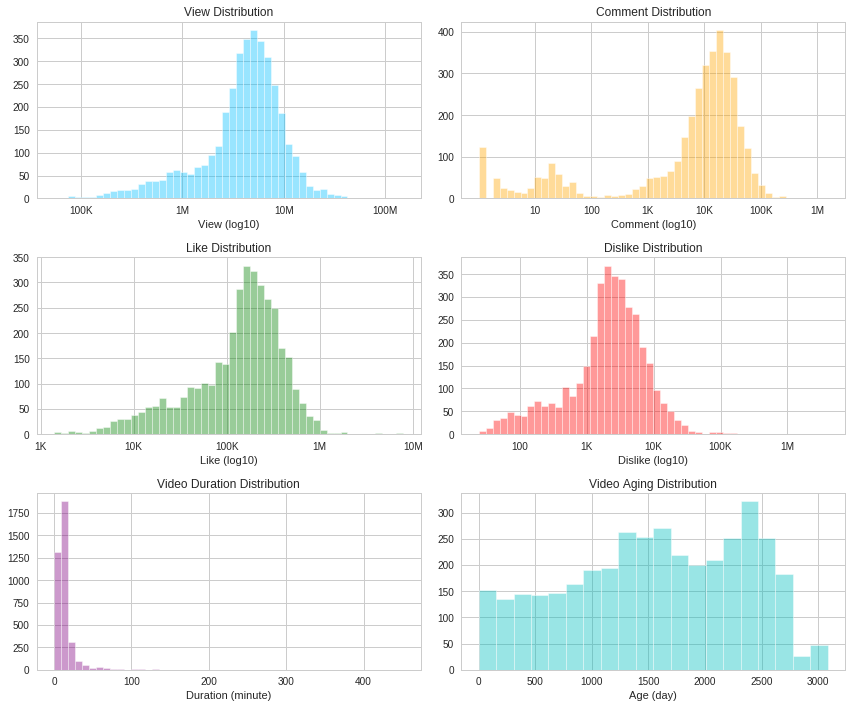

In [21]:
sns.set_style('whitegrid')

e10_labels = ['1','10','100','1K','10K','100K','1M','10M','100M','1B','10B']

# Subplots
f, axes = plt.subplots(3,2, figsize=(12,10))
kws=dict(edgecolor='white', linewidth=1)

# View histogram
ax = sns.distplot(np.log10(videos['view']+1), axlabel='View (log10)', 
                  kde=False, ax=axes[0,0], color='deepskyblue', hist_kws=kws)
ax.set_title('View Distribution')
ax.set_xticks(np.arange(5,9))
ax.set_xticklabels(e10_labels[5:9])

# Comment histogram
ax = sns.distplot(np.log10(videos['comment']+1), axlabel='Comment (log10)', 
                  kde=False, ax=axes[0,1], color='orange', hist_kws=kws)
ax.set_title('Comment Distribution')
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(e10_labels[1:7])

# Like histogram
ax = sns.distplot(np.log10(videos['like']+1), axlabel='Like (log10)', 
                  kde=False, ax=axes[1,0], color='green', hist_kws=kws)
ax.set_title('Like Distribution')
ax.set_xticks(np.arange(3,8))
ax.set_xticklabels(e10_labels[3:8])

# Dislike histogram
ax = sns.distplot(np.log10(videos['dislike']+1), axlabel='Dislike (log10)', 
                  kde=False, ax=axes[1,1], color='red', hist_kws=kws)
ax.set_title('Dislike Distribution')
ax.set_xticks(np.arange(2,7))
ax.set_xticklabels(e10_labels[2:7])

# Duration histogram
ax = sns.distplot(videos['duration'], axlabel='Duration (minute)', 
                  kde=False, ax=axes[2,0], color='purple', hist_kws=kws)
ax.set_title('Video Duration Distribution')

# Age histogram
ax = sns.distplot(videos['age'], axlabel='Age (day)', 
                  kde=False, ax=axes[2,1], color='c', hist_kws=kws)
ax.set_title('Video Aging Distribution')

plt.tight_layout();

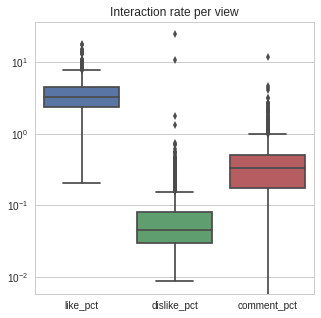

In [22]:
plt.figure(figsize=(5,5))
sns.boxplot(data=videos[['like_pct','dislike_pct','comment_pct']]*100)
plt.title('Interaction rate per view')
plt.yscale('log');